<b>Описание проекта</b>

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

---

<b>Описание тарифов</b>

<b>Тариф «Смарт»</b>  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

<b>Тариф «Ультра»</b>  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
<li><span><a href="#Изучение-тарифов-«Смарт»-и-«Ультра»-и-предобработка-данных" data-toc-modified-id="Изучение-тарифов-«Смарт»-и-«Ультра»-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных и предобработка</a></span>
<ul class="toc-item"><li><span><a href="#Подсчет-данных-для-анализа" data-toc-modified-id="Подсчет-данных-для-анализа-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подсчет данных для анализа</a></span></li></ul></li>
<li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li>
<li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка гипотез</a></span></li>
<li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Изучение тарифов «Смарт» и «Ультра» и предобработка данных
[Содержание](#Содержание)

In [5]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st

In [6]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Кроме того, создадим список названий месяцев month_names. Этот список неоднократно пригодится нам и дальше.

In [7]:
month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

---

Поочередно пройдем по всем датасетам и изучим их на предамет пропусков и неверных типов данных. Сначала датасет с информацией о звонках — <b>calls</b>:

In [8]:
calls.info()
calls.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Пропуски в датасете отсутствуют.

Дата звонка записана строкой, приведем ее к формату datetime. Кроме того отдельным столбцом выделим месяц звонка для того, чтобы потом обрабатывать данные по месяцам.

Есть нулевые значения в столбце duration, надо будет проверить их количество отностиельно всего датасета. Кроме того, дробные значения в столбце duration, согласно условий обслуживания, округлим до целых минут вверх, после чего приведем к целочисленному формату.

Данные в столбце user_id приведем к строчному формату, потому что там у нас не числа, а идентификаторы пользователей.

Кроме того, проеверим датасет на дубликаты.

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_month'] = calls['call_date'].dt.month
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
calls['user_id'] = calls['user_id'].astype('object')
print('Дубликатов в данных о звонках:', len(calls[calls['id'].duplicated() == True]))

Дубликатов в данных о звонках: 0


Дубликатов нет. Теперь взглянем на соотношение звонков длительностью в 0 минут к общему размеру датасета.

In [10]:
len(calls[calls['duration'] == 0]) / len(calls)

0.19551644316336553

Почти 20% всех записей, посмотрим, как нули распределены по пользователям.

count    492.000000
mean       0.196122
std        0.029508
min        0.087719
25%        0.180864
50%        0.195652
75%        0.209269
max        0.500000
Name: id, dtype: float64

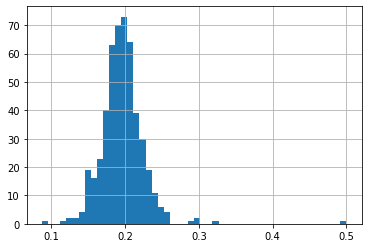

In [12]:
(calls[calls['duration'] == 0].groupby('user_id')['id'].count() / calls.groupby('user_id')['id'].count()).hist(bins=50)
(calls[calls['duration'] == 0].groupby('user_id')['id'].count() / calls.groupby('user_id')['id'].count()).describe()

Получается, нулей примерно одинаковое количество у большинства пользователей. Из условия задания известно, что ноль - это неотвеченный вызов. Поэтому нули оставим как есть в данных, но в дальнейшем, при расчетах средней продолжительности разговора, не забудем исключить их из общего количества звонков.

---

Далее — датасет с информацией о использованном интернете <b>internet</b>:

In [8]:
internet.info()
internet.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Пропуски в этом датасете так же отсутствуют.

В датасете присутствует столбец "Unnamed: 0", судя по всему, равный индексу строки, проверим это, и если это так - удалим этот столбец.

Данные в столбце mb_used хочется привести к целым занчениям, однако делать этого нельзя. Так как трафик считается суммарный за каждый месяц, округлив его в каждой из сессий, мы можем получить ошибку в суммарном за месяц значении. Однако, мы можем привести траффик к гигабайтам, так как все рассчеты в итоге ведутся в гигабайтах. Траффик в гигабайтах запишем в новый столбец gb_used.

Дата начала сессии, как и в таблице со звонками, записана строкой, приведем ее к формату datetime. Кроме того отдельным столбцом выделим из даты месяц для того, чтобы потом обрабатывать данные по месяцам.

И снова данные в столбце user_id приведем к строчному формату, потому что там у нас не числа, а идентификаторы пользователей.

Кроме того, проеверим датасет на дубликаты.

In [9]:
print('Количество строк, в которых "Unnamed: 0" не совпадает с индексом строки:', len(internet[internet['Unnamed: 0'] != internet.index]))

Количество строк, в которых "Unnamed: 0" не совпадает с индексом строки: 0


В датасете нет строк, в которых значение столбца "Unnamed: 0" не было бы равно индексу строки. Получается, этот столбец - копия индекса. Удалим этот столбец безжалостно, попутно выполнив остальные преобразования.

In [10]:
internet = internet.drop(columns='Unnamed: 0')
internet['gb_used'] = internet['mb_used'] / 1024
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_month'] = internet['session_date'].dt.month
internet['user_id'] = internet['user_id'].astype('object')
print('Дубликатов в данных об интернете:', len(internet[internet['id'].duplicated() == True]))

Дубликатов в данных об интернете: 0


Дубликатов нет, и это замечательно.

---

Переходим к следующему датасету: <b>messages</b> — сообщения:

In [11]:
messages.info()
messages.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


И вновь пропуски в датасете отсутствуют.

Дата отправки сообщения тут тоже записана строкой, приведем ее к формату datetime. И снова отдельным столбцом выделим месяц отправки сообщения для того, чтобы потом обрабатывать данные по месяцам.

Данные в столбце user_id опять же приведем к строчному формату.
И привычно уже проеверим датасет на дубликаты.

In [12]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_month'] = messages['message_date'].dt.month
messages['user_id'] = messages['user_id'].astype('object')
print('Дубликатов в данных о сообщениях:', len(messages[messages['id'].duplicated() == True]))

Дубликатов в данных о сообщениях: 0


Данные обработаны, дубликатов нет. Двигаемся дальше.

---

Датасет <b>tariffs</b> — информация о тарифах:

In [13]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


К счастью, тут удалось обойтись без пропусков и ошибок в данных. Так как траффик везде считается в гигабайтах, изменим единицы измерения в информации о тарифе, и изменим название столбца на gb_included.

In [14]:
tariffs['mb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).astype('int')
tariffs.columns = ['messages_included', 'gb_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']
tariffs.head()

,messages_included,gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


---

Последний датасет <b>users</b> — сведения о пользователях:

In [15]:
users.info()
users.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Тип данных в столбце user_id изменим на текст.

В столбце churn_date очень много пропусков, но у нас есть информация, откуда возникли эти пропуски. Пропуск означают, что пользователь на момент выгрузки данных продолжает пользоваться услугами связи. Поэтому мы ничего не будем делать с этими пропусками.

В дальнейшем в проекте нам понадобится сравнивать данные  по Москве с данными по остальным городам, так что создадим на основе столбца city новый стоблец is_moscow с булевым значением, который будет являться фильтром. 

Данные в столбце reg_date приведем к формату datetime.

И, хоть мы и знаем, что у нас информация по 500 пользователям и строк в датасете ровно 500, на всякий случай сделаем проверку на дубликаты.

In [16]:
users['user_id'] = users['user_id'].astype('object')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['is_moscow'] = users['city'] == 'Москва'

print('Дубликатов в данных о пользователях:', len(users[users['user_id'].duplicated() == True]))

Дубликатов в данных о пользователях: 0


Для подсчета выручки с каждого пользователя нам понадобится знать, в какие месяцы пользователь был абонентом, а в какие не был. Для этого создадим датасет на основе users, который будет заполнен нулями и единицами. Если пользователь был абонентом хотя бы день в данном месяце, то будет стоять единица, иначе ноль. В дальнейшем, при подсчете выручки за каждый месяц, мы будем домножать выручку за месяц на единицу или ноль, в зависимости от того, обслуживался ли в данном месяце абонент. Если он не был клиентом, скажем, в марте, то при умножении на ноль мы получим выручку равную нулю.

In [17]:
activity = pd.DataFrame(index=users.index)
for row in users.index:
    for column in range(1,13):
        if users.loc[row, 'reg_date'].month > column:
            activity.loc[row, column] = 0
        elif users.loc[row, 'churn_date'].month < column:
            activity.loc[row, column] = 0
        else:
            activity.loc[row, column] = 1
activity.columns = month_names
activity

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
496,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
498,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


Дубликатов нет, исходные данные предобработаны.

### Подсчет данных для анализа
[Содержание](#Содержание)

Теперь нам необходимо подсчитать следуюущие данные по каждому из пользователей:

* количество сделанных звонков по месяцам;
* количество израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя.

С помощью сводных таблиц сгруппируем данные по каждому пользователю по месяцам. Пропуски, когда пользователь не использовал услуги, заполним нулями. Добавим в данные столбец со среднемесячным значением по каждому пользователю.

Считая среднее по каждому пользователю, важно не забыть, что нам нужно пропустить нулевые значения.

<b>Количество сделанных звонков:</b>

In [18]:
calls_monthly = calls[calls['duration'] != 0].pivot_table(index='user_id', values='duration', columns='call_month', aggfunc=['count']).fillna(0).astype('int')
calls_monthly.columns = month_names
calls_monthly['mean'] = calls_monthly[calls_monthly.loc[:, 'jan':'dec'] != 0].mean(axis=1)
calls_monthly

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
user_id,,,,,,,,,,,,,
1000,0,0,0,0,17,28,41,42,46,44,37,38,36.625000
1001,0,0,0,0,0,0,0,0,0,0,45,47,46.000000
1002,0,0,0,0,0,14,21,37,25,24,25,27,24.714286
1003,0,0,0,0,0,0,0,43,105,97,95,88,85.600000
1004,0,0,0,0,7,25,20,18,18,21,15,15,17.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,13,95,126,112,120,93.200000
1496,6,65,67,52,50,57,63,62,58,56,66,65,55.583333
1497,0,0,0,0,0,0,0,0,0,50,48,58,52.000000


<b>Количество израсходованных минут:</b>

In [19]:
duration_monthly = calls[calls['duration'] != 0].pivot_table(index='user_id', values='duration', columns='call_month', aggfunc=['sum']).fillna(0).astype('int')
duration_monthly.columns = month_names
duration_monthly['mean'] = duration_monthly[duration_monthly.loc[:, 'jan':'dec'] != 0].mean(axis=1)
duration_monthly

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
user_id,,,,,,,,,,,,,
1000,0,0,0,0,159,172,340,408,466,350,338,333,320.750000
1001,0,0,0,0,0,0,0,0,0,0,430,414,422.000000
1002,0,0,0,0,0,117,214,289,206,212,243,236,216.714286
1003,0,0,0,0,0,0,0,380,961,855,824,802,764.400000
1004,0,0,0,0,35,171,135,137,117,145,117,130,123.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,92,813,1030,954,1031,784.000000
1496,48,594,557,521,484,555,582,527,486,450,662,518,498.666667
1497,0,0,0,0,0,0,0,0,0,490,371,545,468.666667


<b>Количество отправленных сообщений:</b>

In [20]:
messages_monthly = messages.pivot_table(index='user_id', values='id', columns='message_month', aggfunc=['count']).fillna(0).astype('int')
messages_monthly.columns = month_names
messages_monthly['mean'] = messages_monthly[messages_monthly.loc[:, 'jan':'dec'] != 0].mean(axis=1)
messages_monthly

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
user_id,,,,,,,,,,,,,
1000,0,0,0,0,22,60,75,81,57,73,58,70,62.0
1002,0,0,0,0,0,4,11,13,4,10,16,12,10.0
1003,0,0,0,0,0,0,0,37,91,83,94,75,76.0
1004,0,0,0,0,95,134,181,151,146,165,158,162,149.0
1005,7,38,56,41,42,47,56,64,52,44,51,54,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,13,82,82,79,84,68.0
1496,9,45,46,49,40,35,42,41,29,35,46,51,39.0
1497,0,0,0,0,0,0,0,0,0,20,14,17,17.0


<b>Объем израсходованного интернет-трафика:</b>

In [21]:
internet_monthly = internet.pivot_table(index='user_id', values='gb_used', columns='session_month', aggfunc=['sum']).fillna(0).apply(np.ceil).astype('int')
internet_monthly.columns = month_names
internet_monthly['mean'] = internet_monthly[internet_monthly.loc[:, 'jan':'dec'] != 0].mean(axis=1)
internet_monthly

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
user_id,,,,,,,,,,,,,
1000,0,0,0,0,3,23,14,14,15,15,15,10,13.625000
1001,0,0,0,0,0,0,0,0,0,0,18,14,16.000000
1002,0,0,0,0,0,11,18,20,17,14,19,18,16.714286
1003,0,0,0,0,0,0,0,9,13,15,12,10,11.800000
1004,0,0,0,0,14,18,22,28,15,19,16,18,18.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,3,33,29,39,23,25.400000
1496,4,28,25,21,24,20,24,23,27,28,25,21,22.500000
1497,0,0,0,0,0,0,0,0,0,12,14,20,15.333333


Эти датасеты пригодятся нам для анализа расхода минут/сообщений/гигабайт траффика в дальнейшем.

Имея датасеты использования минут, сообщений и гигабайт по месяцам по каждому пользователю, мы можем посчитать, какую выручку принес каждый пользователь в каждый конкретный месяц.

---

<b>Посчитаем расходы каждого пользователя на минуты разговоров сверх лимита, заложенного в тарифе.</b>

Создадим новый датасет duration_monthly_tariffed.

Сначала к датасету duration_monthly с общими продолжительностями разговоров добавим информацию о тарифе каждого пользователя. Для этого мы объеденим датасеты duration_monthly и users, а затем удалим ненужные нам столбцы (все, кроме названия тарифа).

In [22]:
duration_monthly_tariffed = duration_monthly.merge(users, right_index=True, on='user_id').drop(columns=['mean', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'is_moscow'])

In [23]:
duration_monthly_tariffed

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,tariff
user_id,,,,,,,,,,,,,
1000,0,0,0,0,159,172,340,408,466,350,338,333,ultra
1001,0,0,0,0,0,0,0,0,0,0,430,414,smart
1002,0,0,0,0,0,117,214,289,206,212,243,236,smart
1003,0,0,0,0,0,0,0,380,961,855,824,802,ultra
1004,0,0,0,0,35,171,135,137,117,145,117,130,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,92,813,1030,954,1031,ultra
1496,48,594,557,521,484,555,582,527,486,450,662,518,smart
1497,0,0,0,0,0,0,0,0,0,490,371,545,smart


После этого, уже имея название тарифа, добавим информацию о лимите количества минут входящих в тариф и стоимости минут сверх лимита для каждого пользователя. Удалим информацию о названии тарифа и о количестве и стоимости сообщений и гигабайтов, ведь сейчас мы считаем перерасход минут звонков и эти данные нам не понадобятся.

In [24]:
duration_monthly_tariffed =  duration_monthly_tariffed.merge(tariffs, right_index=True, on='tariff').drop(columns=['tariff', 'messages_included', 'gb_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message'])

In [25]:
duration_monthly_tariffed

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,minutes_included,rub_per_minute
user_id,,,,,,,,,,,,,,
1000,0,0,0,0,159,172,340,408,466,350,338,333,3000,1
1003,0,0,0,0,0,0,0,380,961,855,824,802,3000,1
1004,0,0,0,0,35,171,135,137,117,145,117,130,3000,1
1013,0,0,0,0,0,0,0,0,0,0,369,567,3000,1
1016,0,0,0,0,0,0,0,0,0,0,28,94,3000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0,0,0,0,0,0,0,262,501,354,411,418,500,3
1496,48,594,557,521,484,555,582,527,486,450,662,518,500,3
1497,0,0,0,0,0,0,0,0,0,490,371,545,500,3


Далее создадим цикл, который будет перебирать каждую ячейку (расход минут в конкретный месяц для каждого конкретного пользователя) и сравнивать значение с количеством минут, входящим в тарифный план данного пользователя. После сравнения цикл будет перезаписывать в ячейку объем использованных данных сверх лимита. 

Логика заполнения датасета следующая:  
Если пользователь не вышел за лимит минут в этом месяце, то в новую ячейку будет записан 0, если же у пользователя произошел перерасход, то в ячейку будет записано количество минут, которые пользователь израсходовал сверх лимита.

После этого отбросим столбец с ежемесячным лимитом минут, далее он нам не понадобится.

In [26]:
for row in duration_monthly_tariffed.index:
    for column in month_names:
        if duration_monthly_tariffed.loc[row, 'minutes_included'] - duration_monthly_tariffed.loc[row, column] >= 0:
            duration_monthly_tariffed.loc[row, column] = 0
        if duration_monthly_tariffed.loc[row, 'minutes_included'] - duration_monthly_tariffed.loc[row, column] < 0:
            duration_monthly_tariffed.loc[row, column] = duration_monthly_tariffed.loc[row, 'minutes_included'] - duration_monthly_tariffed.loc[row, column]
duration_monthly_tariffed.loc[:, 'jan':'dec'] = duration_monthly_tariffed.loc[:, 'jan':'dec'].abs()
duration_monthly_tariffed = duration_monthly_tariffed.drop(columns='minutes_included')

In [27]:
duration_monthly_tariffed

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,rub_per_minute
user_id,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,0,1
1003,0,0,0,0,0,0,0,0,0,0,0,0,1
1004,0,0,0,0,0,0,0,0,0,0,0,0,1
1013,0,0,0,0,0,0,0,0,0,0,0,0,1
1016,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0,0,0,0,0,0,0,0,1,0,0,0,3
1496,0,94,57,21,0,55,82,27,0,0,162,18,3
1497,0,0,0,0,0,0,0,0,0,0,0,45,3


Создадим новый цикл, в котором посчитаем, сколько рублей каждый пользователь ежемесячно заплатил за минуты, израсходованные сверх лимита. Для этого перемножим количество минут сверх лимита со стоимостью минуты для каждого пользователя, согласно его тарифа. 

После выполнения цикла удалим столбец со стоимостью минуты сверх лимита.

In [28]:
for row in duration_monthly_tariffed.index:
    for column in month_names:
        duration_monthly_tariffed.loc[row, column] = duration_monthly_tariffed.loc[row, 'rub_per_minute'] * duration_monthly_tariffed.loc[row, column]
duration_monthly_tariffed = duration_monthly_tariffed.drop(columns='rub_per_minute')

In [29]:
duration_monthly_tariffed

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
user_id,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,0,0
1013,0,0,0,0,0,0,0,0,0,0,0,0
1016,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0,0,0,0,0,0,0,0,3,0,0,0
1496,0,282,171,63,0,165,246,81,0,0,486,54
1497,0,0,0,0,0,0,0,0,0,0,0,135


Из-за того, что не все пользователи за период измерения совершали хоть какие-то звонки, датасет duration_monthly_tariffed короче датасета users.

Это помешает нам при рассчете выручки с каждого пользователя. Поэтому отбросим из датасета users всё кроме индекса и user_id, а затем объединим наш датасет с этим "списком абонентов". У нас образуются пропуски, которые мы заполним нулями. Суммы приведем к целочисленному типу.

In [30]:
duration_monthly_tariffed = users.drop(columns=['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff', 'is_moscow']).merge(duration_monthly_tariffed, how='left', on='user_id').fillna(0)
duration_monthly_tariffed.loc[:, 'jan':'dec'] = duration_monthly_tariffed.loc[:, 'jan':'dec'].astype('int')

In [31]:
duration_monthly_tariffed

,user_id,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1000,0,0,0,0,0,0,0,0,0,0,0,0
1,1001,0,0,0,0,0,0,0,0,0,0,0,0
2,1002,0,0,0,0,0,0,0,0,0,0,0,0
3,1003,0,0,0,0,0,0,0,0,0,0,0,0
4,1004,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,0,0,0,0,0
496,1496,0,282,171,63,0,165,246,81,0,0,486,54
497,1497,0,0,0,0,0,0,0,0,0,0,0,135
498,1498,0,0,0,0,0,0,0,0,0,0,0,0


Теперь у нас есть датасет по выручке со звонков сверх заложенного в тариф лимита по всем пользователям, даже тем, которые эти звонки не совершали вовсе.

Аналогичным образом создадим датасеты с информацией о расходах пользователей на сообщения и интернет-траффик сверх лимитов. Циклы и логика будут похожими, отличаться будут только названия столбцов, которые мы будем оставлять и отбрасывать.

<b>Примечание:</b> Досчитав два датасета ниже, я подумал о том, что можно было бы выполнить рассчеты этих трех датасетов в одном цикле, так как логика в них идентичная, а изменящиеся значения можно описать в словаре. Но дело в том, что эту работу я делал в конце второй недели спринта и решил не затягивать сдачу. :)

---

<b>Посчитаем стоимость сообщений, израсходованных сверх лимита.</b>

In [32]:
messages_monthly_tariffed = messages_monthly.merge(users, right_index=True, on='user_id').drop(columns=['mean', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'is_moscow'])

In [33]:
messages_monthly_tariffed =  messages_monthly_tariffed.merge(tariffs, right_index=True, on='tariff').drop(columns=['tariff', 'minutes_included', 'gb_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_minute'])

In [34]:
for row in messages_monthly_tariffed.index:
    for column in month_names:
        if messages_monthly_tariffed.loc[row, 'messages_included'] - messages_monthly_tariffed.loc[row, column] >= 0:
            messages_monthly_tariffed.loc[row, column] = 0
        if messages_monthly_tariffed.loc[row, 'messages_included'] - messages_monthly_tariffed.loc[row, column] < 0:
            messages_monthly_tariffed.loc[row, column] = messages_monthly_tariffed.loc[row, 'messages_included'] - messages_monthly_tariffed.loc[row, column]
messages_monthly_tariffed.loc[:, 'jan':'dec'] = messages_monthly_tariffed.loc[:, 'jan':'dec'].abs()
messages_monthly_tariffed = messages_monthly_tariffed.drop(columns='messages_included')

In [35]:
for row in messages_monthly_tariffed.index:
    for column in month_names:
        messages_monthly_tariffed.loc[row, column] = messages_monthly_tariffed.loc[row, 'rub_per_message'] * messages_monthly_tariffed.loc[row, column]
messages_monthly_tariffed = messages_monthly_tariffed.drop(columns='rub_per_message')

In [36]:
messages_monthly_tariffed = users.drop(columns=['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff', 'is_moscow']).merge(messages_monthly_tariffed, how='left', on='user_id').fillna(0)
messages_monthly_tariffed.loc[:, 'jan':'dec'] = messages_monthly_tariffed.loc[:, 'jan':'dec'].astype('int')
messages_monthly_tariffed

,user_id,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1000,0,0,0,0,0,0,0,0,0,0,0,0
1,1001,0,0,0,0,0,0,0,0,0,0,0,0
2,1002,0,0,0,0,0,0,0,0,0,0,0,0
3,1003,0,0,0,0,0,0,0,0,0,0,0,0
4,1004,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,0,0,0,0,0
496,1496,0,0,0,0,0,0,0,0,0,0,0,3
497,1497,0,0,0,0,0,0,0,0,0,0,0,0
498,1498,0,0,0,0,0,0,0,36,0,0,0,0


<b>Посчитаем стоимость интернет-траффика, израсходованного сверх лимита.</b>

In [37]:
internet_monthly_tariffed = internet_monthly.merge(users, right_index=True, on='user_id').drop(columns=['mean', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'is_moscow'])

In [38]:
internet_monthly_tariffed =  internet_monthly_tariffed.merge(tariffs, right_index=True, on='tariff').drop(columns=['tariff', 'minutes_included', 'messages_included', 'rub_monthly_fee', 'rub_per_message', 'rub_per_minute'])

In [39]:
for row in internet_monthly_tariffed.index:
    for column in month_names:
        if internet_monthly_tariffed.loc[row, 'gb_included'] - internet_monthly_tariffed.loc[row, column] >= 0:
            internet_monthly_tariffed.loc[row, column] = 0
        if internet_monthly_tariffed.loc[row, 'gb_included'] - internet_monthly_tariffed.loc[row, column] < 0:
            internet_monthly_tariffed.loc[row, column] = internet_monthly_tariffed.loc[row, 'gb_included'] - internet_monthly_tariffed.loc[row, column]
internet_monthly_tariffed.loc[:, 'jan':'dec'] = internet_monthly_tariffed.loc[:, 'jan':'dec'].abs()
internet_monthly_tariffed = internet_monthly_tariffed.drop(columns='gb_included')

In [40]:
for row in internet_monthly_tariffed.index:
    for column in month_names:
        internet_monthly_tariffed.loc[row, column] = internet_monthly_tariffed.loc[row, 'rub_per_gb'] * internet_monthly_tariffed.loc[row, column]
internet_monthly_tariffed = internet_monthly_tariffed.drop(columns='rub_per_gb')

In [41]:
internet_monthly_tariffed = users.drop(columns=['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff', 'is_moscow']).merge(internet_monthly_tariffed, how='left', on='user_id').fillna(0)
internet_monthly_tariffed.loc[:, 'jan':'dec'] = internet_monthly_tariffed.loc[:, 'jan':'dec'].astype('int')
internet_monthly_tariffed

,user_id,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1000,0,0,0,0,0,0,0,0,0,0,0,0
1,1001,0,0,0,0,0,0,0,0,0,0,600,0
2,1002,0,0,0,0,0,0,600,1000,400,0,800,600
3,1003,0,0,0,0,0,0,0,0,0,0,0,0
4,1004,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,0,450,0,1350,0
496,1496,0,2600,2000,1200,1800,1000,1800,1600,2400,2600,2000,1200
497,1497,0,0,0,0,0,0,0,0,0,0,0,1000
498,1498,0,0,0,0,0,0,0,1800,1400,1200,0,0


<b>Подсчет помесячной выручки с каждого пользователя</b>

На базе датасетов users и tariffs создадим новый датасет revenue, в котором оставим только индексы и столбцы user_id, tariff, rub_monthly_fee и is_moscow. Они понадабятся нам для того, чтобы сравнить выручку по пользователям разных тарифов и москвичам с остальными жителями страны.

In [42]:
revenue = users.merge(tariffs, how='left', on='tariff').drop(columns=['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'messages_included', 'gb_included', 'minutes_included', 'rub_per_gb', 'rub_per_message', 'rub_per_minute'])

В цикле сложим базовую стоимость тарифа, значение доходов сверх тарифа по каждому пользователю из трех датаестов (по минутам разговора, отправленым сообщениям и интернет-траффику), после чего помножим сумму на соответствующее значение из датасета activity. 

Результат вычисления допишем в датасет revenue. После выполнения цикла отбросим столбец с размером ежемесячного платежа, он в этом датасете нам больше не понадобится.

In [43]:
for row in revenue.index:
    for column in month_names:
        revenue.loc[row, column] = (revenue.loc[row, 'rub_monthly_fee'] + duration_monthly_tariffed.loc[row, column] + messages_monthly_tariffed.loc[row, column] + internet_monthly_tariffed.loc[row, column]) * activity.loc[row, column]
revenue = revenue.drop(columns='rub_monthly_fee')

В итоге получим датасет revenue с помесячной выручкой с каждого пользователя. Данные о доходах приведем к целочисленному типу и добавим столбец со средним значением по каждому пользователю.

In [44]:
revenue.loc[:, 'jan':'dec'] = revenue.loc[:, 'jan':'dec'].astype('int')
revenue['mean'] = revenue[revenue.loc[:, 'jan':'dec'] != 0].mean(axis=1)
revenue

,user_id,tariff,is_moscow,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
0,1000,ultra,False,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950.000000
1,1001,smart,True,0,0,0,0,0,0,0,0,0,0,1150,550,850.000000
2,1002,smart,False,0,0,0,0,0,550,1150,1550,950,550,1350,1150,1035.714286
3,1003,ultra,True,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950.000000
4,1004,ultra,False,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,ultra,False,0,0,0,0,0,0,0,1950,2400,1950,3300,1950,2310.000000
496,1496,smart,False,550,3432,2721,1813,2350,1715,2596,2231,2950,3150,3036,1807,2362.583333
497,1497,smart,False,0,0,0,0,0,0,0,0,0,550,550,1685,928.333333
498,1498,smart,False,0,0,0,0,0,0,550,2386,1950,1750,0,0,1659.000000


## Анализ данных
[Содержание](#Содержание)

<b>Анализ израсходованных пользователями минут разговоров</b>

Создадим специалььный датасет, по которому и будем проводить анализ и делать выводы. Для этого добавим к датасету duration_monthly информацию о тарифе каждого пользователя. Далее аналогичным же образом создадим датасету для сообщений и интернет-траффика.

In [45]:
duration_analysys = duration_monthly.merge(users, right_index=True, on='user_id').drop(columns=['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'is_moscow'])

In [46]:
print('Cреднемесячное количество использованных минут пользователями тарифа "Смарт"')
print()
print('Среднее значение:', duration_analysys[duration_analysys['tariff'] == 'smart']['mean'].mean())
print('Дисперсия:', np.var(duration_analysys[duration_analysys['tariff'] == 'smart']['mean']))
print('Стандартное отклонение:', np.std(duration_analysys[duration_analysys['tariff'] == 'smart']['mean']))

Cреднемесячное количество использованных минут пользователями тарифа "Смарт"

Среднее значение: 420.8480194908561
Дисперсия: 20519.31269910389
Стандартное отклонение: 143.24563762678392


In [47]:
print('Cреднемесячное количество использованных минут пользователями тарифа "Ультра"')
print()
print('Среднее значение:', duration_analysys[duration_analysys['tariff'] == 'ultra']['mean'].mean())
print('Дисперсия:', np.var(duration_analysys[duration_analysys['tariff'] == 'ultra']['mean']))
print('Стандартное отклонение:', np.std(duration_analysys[duration_analysys['tariff'] == 'ultra']['mean']))

Cреднемесячное количество использованных минут пользователями тарифа "Ультра"

Среднее значение: 546.9984013461286
Дисперсия: 71369.465258898
Стандартное отклонение: 267.1506415094263


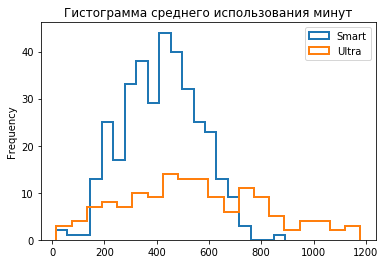

In [48]:
ax = duration_analysys[duration_analysys['tariff'] == 'smart'].plot(title='Гистограмма среднего использования минут', kind='hist', y='mean', histtype='step', linewidth=2, label='Smart', bins=20)
duration_analysys[duration_analysys['tariff'] == 'ultra'].plot(kind='hist', y='mean', ax=ax, histtype='step', linewidth=2, label='Ultra', bins=20);

<b>Вывод:</b> Из гистрограмм видно, что оба распределения нормальные. В среднем, пользователь тарифа "Смарт" в месяц использует 420 минут разговоров, а пользователь тарифа "Ультра" — 546 минут. Дисперсия этого показателя у пользователей тарифа "Ультра" выше, чем у пользователей тарифа "Смарт". Это значит, что пользователи тарифа "Смарт" более постоянны в количестве израсходованных минут, и стараются держаться в пределах заложенного в тарифе количества. Пользователи более дорогого тарифа "Ультра" наоборот, похоже, менее склонны следить за количеством израсходованных минут, благо в тариф их входит предостаточно.

В тариф "Ультра" входит 3000 минут разговоров, однако в среднем никто в гнеральной выборке не израсходовал более 1200 минут в месяц. В данной работе нам как представителю оператора сотовой связи это выгодно, мы ежемесячно продаем пользователям количество минут более чем в два раза превышающее их потребности.

<b>Анализ израсходованных пользователями сообщений</b>

In [49]:
messages_analysys = messages_monthly.merge(users, right_index=True, on='user_id').drop(columns=['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'is_moscow'])

In [50]:
print('Cреднемесячное количество отправленных сообщений пользователями тарифа "Смарт"')
print()
print('Среднее значение:', messages_analysys[messages_analysys['tariff'] == 'smart']['mean'].mean())
print('Дисперсия:', np.var(messages_analysys[messages_analysys['tariff'] == 'smart']['mean']))
print('Стандартное отклонение:', np.std(messages_analysys[messages_analysys['tariff'] == 'smart']['mean']))

Cреднемесячное количество отправленных сообщений пользователями тарифа "Смарт"

Среднее значение: 37.57560563057251
Дисперсия: 615.4647631537796
Стандартное отклонение: 24.80856229517905


In [51]:
print('Cреднемесячное количество отправленных сообщений пользователями тарифа "Ультра"')
print()
print('Среднее значение:', messages_analysys[messages_analysys['tariff'] == 'ultra']['mean'].mean())
print('Дисперсия:', np.var(messages_analysys[messages_analysys['tariff'] == 'ultra']['mean']))
print('Стандартное отклонение:', np.std(messages_analysys[messages_analysys['tariff'] == 'ultra']['mean']))

Cреднемесячное количество отправленных сообщений пользователями тарифа "Ультра"

Среднее значение: 64.55580197132616
Дисперсия: 1867.5617883826283
Стандартное отклонение: 43.21529576877414


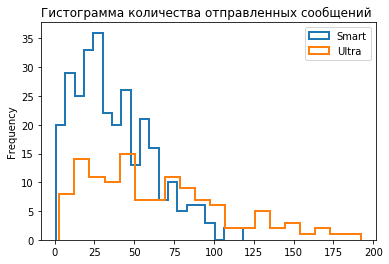

In [52]:
ax = messages_analysys[messages_analysys['tariff'] == 'smart'].plot(title='Гистограмма количества отправленных сообщений ', kind='hist', y='mean', histtype='step', linewidth=2, label='Smart', bins=20)
messages_analysys[messages_analysys['tariff'] == 'ultra'].plot(kind='hist', y='mean', ax=ax, histtype='step', linewidth=2, label='Ultra', bins=20);

<b>Вывод:</b> В данном случае у пользователей обоих тарифов количество использованных сообщений распределяется согласно распределения Пуассона.

В среднем, пользователь тарифа "Смарт" в месяц отправляет 37, а пользователь тарифа "Ультра" — 64 сообщений. Дисперсия этого показателя у пользователей тарифа "Ультра"  в два раза выше, чем у пользователей тарифа "Смарт", это происходит из-за того, что имея в запасе аж 1000 сообщений, пользователи тарифа "Ультра" не следят, сколько сообщений они используют, иногда больше, иногда меньше.

Пользователи же тарифа "Смарт" наоборот стараются держаться в пределах заложенных в тарифе 50 сообщений. И у многих это даже получается. Однако, довольно много пользователей (порядка 25%) не хватает объема, заложенного в тарифе.

Вообще, я искренне удивлен, что в 2018 году так популярны сообщения, мне казалось, месссенджеры к тому моменту уже окончательно победили СМС-сообщения.

<b>Анализ израсходованного пользователямии интернет-траффика</b>

In [53]:
internet_analysys = internet_monthly.merge(users, right_index=True, on='user_id').drop(columns=['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'is_moscow'])

In [54]:
print('Cреднемесячное количество использованного траффика пользователями тарифа "Смарт"')
print()
print('Среднее значение:', internet_analysys[internet_analysys['tariff'] == 'smart']['mean'].mean())
print('Дисперсия:', np.var(internet_analysys[internet_analysys['tariff'] == 'smart']['mean']))
print('Стандартное отклонение:', np.std(internet_analysys[internet_analysys['tariff'] == 'smart']['mean']))

Cреднемесячное количество использованного траффика пользователями тарифа "Смарт"

Среднее значение: 16.343947433518863
Дисперсия: 12.524040104049512
Стандартное отклонение: 3.5389320569982


In [55]:
print('Cреднемесячное количество использованного траффика пользователями тарифа "Ультра"')
print()
print('Среднее значение:', internet_analysys[internet_analysys['tariff'] == 'ultra']['mean'].mean())
print('Дисперсия:', np.var(internet_analysys[internet_analysys['tariff'] == 'ultra']['mean']))
print('Стандартное отклонение:', np.std(internet_analysys[internet_analysys['tariff'] == 'ultra']['mean']))

Cреднемесячное количество использованного траффика пользователями тарифа "Ультра"

Среднее значение: 19.758316400153138
Дисперсия: 63.08177733555937
Стандартное отклонение: 7.942403750475002


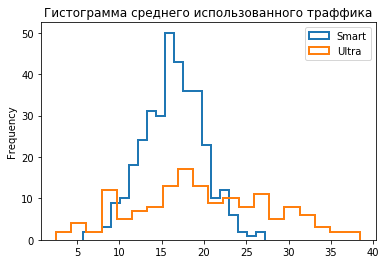

In [56]:
ax = internet_analysys[internet_analysys['tariff'] == 'smart'].plot(title='Гистограмма среднего использованного траффика', kind='hist', y='mean', histtype='step', linewidth=2, label='Smart', bins=20)
internet_analysys[internet_analysys['tariff'] == 'ultra'].plot(kind='hist', y='mean', ax=ax, histtype='step', linewidth=2, label='Ultra', bins=20);

<b>Вывод:</b> Распределение значений обоих показателей нормальное.

Средние значения у пользователей обоих тарифов достаточно близки, учитывая, что в тарифе "Ультра" заложено в два раза больше гигибайт: "Смарт" — 16 гб/мес., "Ультра" — 19 гб/мес. Однако, дисперсия у пользователей тарифа "Ультра" выше в 5 раз. И по гистограмме видно, что расход у пользователей тарифа "Ультра" более размыт. 

Пользователи обоих тарифов достаточно часто используют больше траффика, чем заложено в тарифах. Вполне возможно, тарифы к 2018 году уже успели устареть и необходимый среднему пользователю объем данных вырос. 

## Проверка гипотез
[Содержание](#Содержание)

Проверим две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

Для проверки гипотез в данном разделе мы будем использовать заранее подготовленный датасет revenue.

Гипотезы формулируем таким образом, чтобы нулевая гипотеза заявляла о равенстве двух параметров, а альтернативная о неравенстве.

Не смотря на то, что датасет у нас один, проверяемые выборки независимы, имеют разные размеры, поэтому будем использовать метод ttest_ind.

Значение alpha возьмем 0,05.

<b>Нулевая гипотеза:</b> выручка от пользователей тарифов «Ультра» и «Смарт» равна.  
<b>Альтернативная гипотеза:</b> выручка от пользователей тарифов «Ультра» и «Смарт» различается.

In [57]:
print('Cреднемесячная выручка от пользователя тарифа "Смарт"')
print()
print('Процент пользователей тарифа "Смарт" в выборке: {:.1%}'.format(len(revenue[revenue['tariff'] == 'smart'])/len(revenue)))
print('Среднее значение:', revenue[revenue['tariff'] == 'smart']['mean'].mean())
print('Дисперсия:', np.var(revenue[revenue['tariff'] == 'smart']['mean']))
print('Стандартное отклонение:', np.std(revenue[revenue['tariff'] == 'smart']['mean']))

Cреднемесячная выручка от пользователя тарифа "Смарт"

Процент пользователей тарифа "Смарт" в выборке: 70.2%
Среднее значение: 1322.1947485641929
Дисперсия: 366896.02779298875
Стандартное отклонение: 605.7194299285675


In [58]:
print('Cреднемесячная выручка от пользователя тарифа "Ультра"')
print()
print('Процент пользователей тарифа "Ультра" в выборке: {:.1%}'.format(len(revenue[revenue['tariff'] == 'ultra'])/len(revenue)))
print('Среднее значение:', revenue[revenue['tariff'] == 'ultra']['mean'].mean())
print('Дисперсия:', np.var(revenue[revenue['tariff'] == 'ultra']['mean']))
print('Стандартное отклонение:', np.std(revenue[revenue['tariff'] == 'ultra']['mean']))

Cреднемесячная выручка от пользователя тарифа "Ультра"

Процент пользователей тарифа "Ультра" в выборке: 29.8%
Среднее значение: 2085.548788459862
Дисперсия: 88049.66450621308
Стандартное отклонение: 296.7316371845326


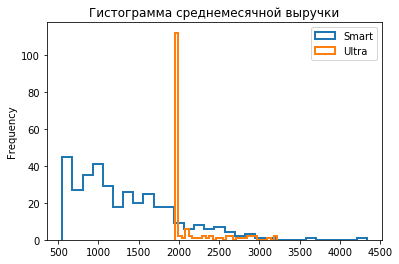

In [59]:
ax = revenue[revenue['tariff'] == 'smart'].plot(title='Гистограмма среднемесячной выручки', kind='hist', y='mean', histtype='step', linewidth=2, label='Smart', bins=30)
revenue[revenue['tariff'] == 'ultra'].plot(kind='hist', y='mean', ax=ax, histtype='step', linewidth=2, label='Ultra', bins=30);

In [60]:
alpha = .05

results_tariffs = st.ttest_ind(revenue[revenue['tariff'] == 'smart']['mean'], revenue[revenue['tariff'] == 'ultra']['mean'])

print('p-значение:', results_tariffs.pvalue)

if (results_tariffs.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4760419872988006e-40
Отвергаем нулевую гипотезу


<b>Нулевая гипотеза отвергается.</b> Средняя выручка от пользователей тарифов "Смарт" и "Ультра" различна.

Кроме того, на гистограммах видно, что большинство пользователей тарифа "Ультра" приносит сумму около 2000 рублей в месяц, что равно размеру оплаты за сам тариф. Это значит, что большинство пользователей не выходит за пределы заложенных в тариф минут/сообщений/гигабайт траффика. У гистограммы пользователей тарифа "Смарт" длинный и достаточно пологий ховст, означающий, что большинство пользователей тарифа выходит за пределы заложенных в тариф пакетов.

<b>Нулевая гипотеза:</b> средняя выручка от пользователей из Москвы равна выручке от пользователей из других регионов.  
<b>Альтернативная гипотеза:</b> средняя выручка от пользователей из Москвы отличается от выручки от пользователей из других регионов.

In [61]:
print('Cреднемесячное количество использованного траффика пользователями тарифа "Смарт"')
print()
print('Процент пользователей из Москвы в выборке: {:.1%}'.format(len(revenue[revenue['is_moscow'] == True])/len(revenue)))
print('Среднее значение:', revenue[revenue['is_moscow'] == True]['mean'].mean())
print('Дисперсия:', np.var(revenue[revenue['is_moscow'] == True]['mean']))
print('Стандартное отклонение:', np.std(revenue[revenue['is_moscow'] == True]['mean']))

Cреднемесячное количество использованного траффика пользователями тарифа "Смарт"

Процент пользователей из Москвы в выборке: 19.8%
Среднее значение: 1498.465851152215
Дисперсия: 364100.0204568282
Стандартное отклонение: 603.4070106129263


In [62]:
print('Cреднемесячное количество использованного траффика пользователями тарифа "Ультра"')
print()
print('Процент пользователей не из Москвы в выборке: {:.1%}'.format(len(revenue[revenue['is_moscow'] == False])/len(revenue)))
print('Среднее значение:', revenue[revenue['is_moscow'] == False]['mean'].mean())
print('Дисперсия:', np.var(revenue[revenue['is_moscow'] == False]['mean']))
print('Стандартное отклонение:', np.std(revenue[revenue['is_moscow'] == False]['mean']))

Cреднемесячное количество использованного траффика пользователями тарифа "Ультра"

Процент пользователей не из Москвы в выборке: 80.2%
Среднее значение: 1562.3167255922244
Дисперсия: 415163.4416990662
Стандартное отклонение: 644.3317792093342


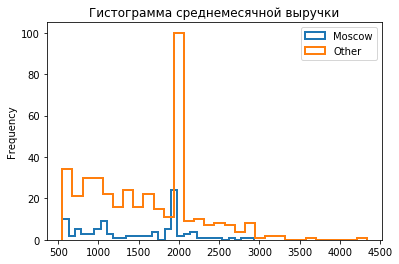

In [63]:
ax = revenue[revenue['is_moscow'] == True].plot(title='Гистограмма среднемесячной выручки', kind='hist', y='mean', histtype='step', linewidth=2, label='Moscow', bins=30)
revenue[revenue['is_moscow'] == False].plot(kind='hist', y='mean', ax=ax, histtype='step', linewidth=2, label='Other', bins=30);

In [64]:
alpha = .05

results_moscow = st.ttest_ind(revenue[revenue['is_moscow'] == True]['mean'], revenue[revenue['is_moscow'] == False]['mean'])

print('p-значение:', results_moscow.pvalue)

if (results_moscow.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.37273509521850456
Не получилось отвергнуть нулевую гипотезу


<b>Нулевую гипотезу не удалось отвергнуть.</b> Средняя выручка от пользователей из Москвы равна средней выручке пользователей из других регионов.

Гистограммы обеих выборок похожи, только гистограмма других регионов выше, так как там в 4 раза больше данных, чем в гистограмме москвичей. Однако сами эти гистограммы очень похожи, обе имеют два пика в районе стоимостей тарифов 550 и 1950. При этом пик около 550 менее явный, так как выше мы увидели, большинство пользователей тарифа "Смарт" в итоге платят больше стоимости тарифа.

## Общий вывод
[Содержание](#Содержание)

Для начала опишем среднего пользователя каждого тарифа:

<b>Средний пользователь тарифа "Смарт":</b>
* использует в месяц 420 минут разговоров
* отправляет в месяц 37 сообщений
* расходует в месяц 16 гигабайт интернет-траффика
* платит 1322 рублей в месяц
* составляет 70,2% генеральной выборки пользователей

<b>Средний пользователь тарифа "Ультра":</b>
* использует в месяц 546 минут разговоров
* отправляет в месяц 64 сообщений
* расходует в месяц 19 гигабайт интернет-траффика
* платит 2085 рублей в месяц
* составляет 29,8% генеральной выборки пользователей

Не смотря на то, что пользователь тарифа "Смарт" в среднем приносит меньше выручки, чем пользователи тарифа "Ультра", пользователи тарифа "Смарт" переплачивают более чем в 2 раза сверх стоимости своего тарифа. Кроме того, пользователи видимо не готовы переплачивать за лимиты тарифа "Ультра", которых они врядли когда либо достигнут (3000 минут разговоров и 1000 сообщений).Из предложенных двух тарифов выгоднее вложиться в рекламу тарифа "Смарт", чтобы привлечь туда больше пользователей.

Однако, как мне показалось, представленные тарифы усатрели, особенно в части входящего в них объема интернет-траффика. Пользователи регулярно "вылезают" за рамки заложенные в тарифе. И хоть это и приносит нам дополнительную прибыль, постоянное ощущение у пользователя, что ему не хватает траффика может негативно сказаться на отношении пользователя к тарифу. Пользователь может начать искать тарифы с большими объемами траффика. Кроме того высокие лимиты в тарифе "Ультра" создают впечатление, что пользователь переплачивает за то, чем он не пользуется.

Я бы предложил увеличить объемы интернет-траффика в тарифах "Смарт" и "Ультра" до 20 и 40 гигабайт соответственно, уменьшить лимиты на звонки и сообщения в тарифе "Ультра", преподнеся новые тарифы, как более актуальные, направленные на интернет связь.

---

Кроме того, были проверены две гипотезы, результаты оказались следующими:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
* средняя выручка от пользователи из Москвы равна от выручке от пользователей из других регионов